In [1]:
%matplotlib inline
%load_ext autoreload


import torch
import torch.nn.functional as F
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
from laughter_classification.sspnet_data_sampler import SSPNetDataSampler
from laughter_prediction.feature_extractors import LibrosaExtractor
from sklearn.model_selection import train_test_split
from laughter_prediction.rnn import LibrosaFeaturesRnn
from laughter_prediction.predictors import RnnPredictor
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import matplotlib.pyplot as plt


In [2]:
!mkdir -p data

## Cмотирим на данные

In [3]:
directory = 'vocalizationcorpus/data'
audio_files = list(sorted(os.listdir('vocalizationcorpus/data')))

audio_file = directory + '/' + audio_files[0]
audio_file

'vocalizationcorpus/data/S0001.wav'

(128, 474)


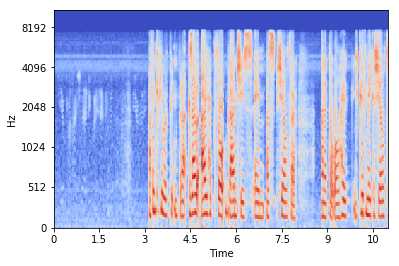

In [4]:
y, sr = librosa.load(audio_file)
S = librosa.feature.melspectrogram(y, sr)
S = librosa.power_to_db(S)

print(S.shape)
librosa.display.specshow(S, sr=sr, x_axis='time', y_axis='mel')

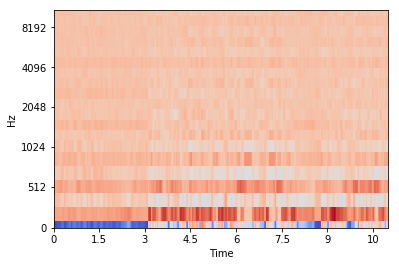

In [5]:
y, sr = librosa.load(audio_file)
S = librosa.feature.mfcc(y, sr)
librosa.display.specshow(S, sr=sr, x_axis='time', y_axis='mel')

In [6]:
extractor = LibrosaExtractor()
extractor.extract_features(audio_file).head()

,fbank_000,fbank_001,fbank_002,fbank_003,fbank_004,fbank_005,fbank_006,fbank_007,fbank_008,fbank_009,...,mfcc_010,mfcc_011,mfcc_012,mfcc_013,mfcc_014,mfcc_015,mfcc_016,mfcc_017,mfcc_018,mfcc_019
0,-14.770546,-7.502573,-14.677981,-10.937127,-21.269282,-39.300535,-43.299913,-38.613908,-20.862417,-16.210959,...,7.274429,11.029847,10.672556,-0.565825,19.375721,1.419888,6.978270,-2.037510,20.511622,8.859711
1,-16.770523,-8.677541,-18.883031,-33.635306,-29.146382,-23.314792,-15.536017,-10.014064,-25.719489,-35.669000,...,-16.901669,-7.184055,-19.194132,-17.970590,12.663122,-0.107084,20.268938,1.372494,-7.076095,8.931564
2,-12.352719,-4.444362,-14.673733,-42.556730,-17.731121,-11.759801,-19.046962,-15.194353,-23.255466,-19.323618,...,-11.666725,2.564224,-4.208590,-11.211039,16.965807,16.649665,23.453795,11.212921,9.460361,-13.224893
3,-15.440580,-7.917505,-18.145880,-45.599949,-29.652522,-23.691098,-19.468875,-14.010716,-25.302332,-22.604453,...,-0.191644,9.514174,-7.796018,-7.132752,11.623116,8.058064,21.677039,-1.138147,-2.169490,-5.259990
4,-18.958624,-11.360067,-18.807546,-15.593530,-23.763246,-21.985535,-24.705120,-19.680730,-22.500579,-18.102045,...,-14.405206,-4.518877,4.056877,6.588490,14.185785,-15.692512,3.539914,12.142542,9.761851,3.887359


## Считываем признаки

In [7]:
SAMPLE_RATE = 16000
FRAME_SEC = 0.3

In [8]:
sampler = SSPNetDataSampler('vocalizationcorpus')

In [9]:
data = sampler.create_sampled_df(FRAME_SEC, save_path='data/sampled.csv')

/home/maxim/PycharmProjects/speech-ml-hw/2/homework/laughter_classification/sspnet_data_sampler.py:112: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  return pd.DataFrame.from_csv(save_path, index_col=None)


In [10]:
data

,fbank_000,fbank_001,fbank_002,fbank_003,fbank_004,fbank_005,fbank_006,fbank_007,fbank_008,fbank_009,...,mfcc_012,mfcc_013,mfcc_014,mfcc_015,mfcc_016,mfcc_017,mfcc_018,mfcc_019,IS_LAUGHTER,SNAME
0,-19.512337,-10.751633,-14.777827,-18.966939,-16.917103,-18.246705,-20.162993,-18.075304,-17.600648,-18.778584,...,8.756960,-14.857754,22.649179,-15.996658,12.870518,-10.768023,6.965929,-3.087592,0,S0001
1,-16.418212,-11.479087,-15.647148,-18.000653,-16.257974,-18.293827,-19.216450,-17.100311,-17.355976,-18.953886,...,9.974392,-17.866732,21.224710,-12.295156,15.577631,-11.913397,5.912433,-2.406997,0,S0001
2,-19.561318,-14.155631,-16.500950,-19.259373,-15.947509,-18.508480,-17.752083,-18.735773,-20.000116,-18.555955,...,11.887583,-15.699741,18.171677,-13.792290,8.600648,-10.910454,7.183778,-5.662854,0,S0001
3,-19.069293,-13.010108,-17.266277,-16.038272,-13.717408,-16.670910,-19.712922,-18.614219,-19.417061,-19.828697,...,6.627427,-9.134603,24.201275,-19.071646,13.919328,-5.860380,2.450502,-8.587574,0,S0001
4,-15.080133,-9.803062,-15.000448,-16.308712,-16.056597,-17.036844,-19.208406,-17.545893,-20.549559,-17.875918,...,12.126552,-17.691907,21.201253,-14.738738,12.562647,-8.362024,5.665779,-4.746374,0,S0001
5,-16.768311,-10.336495,-15.832604,-16.880480,-14.970650,-18.038281,-20.697990,-19.351725,-21.673575,-21.253379,...,11.975913,-12.901809,24.117082,-15.677362,14.176729,-4.046529,2.868359,-8.642527,0,S0001
6,-18.152393,-13.111996,-18.351703,-17.225439,-14.967807,-18.456091,-17.151680,-15.648074,-16.994343,-18.038206,...,7.246362,-14.432793,20.468048,-17.810742,9.385266,-9.466130,3.346170,-5.362977,0,S0001
7,-17.162352,-12.888983,-17.996707,-19.491615,-18.377252,-16.595850,-18.217371,-17.095571,-16.184384,-17.890604,...,9.661401,-15.591358,22.338917,-16.937508,8.823653,-13.398335,4.027778,-3.166383,0,S0001
8,-21.760583,-17.076791,-17.519815,-17.840089,-15.205841,-15.410737,-19.382010,-16.272773,-15.181722,-17.153874,...,6.881137,-13.332776,20.765922,-16.207669,8.292226,-13.345987,1.548566,-2.481757,0,S0001
9,-20.976208,-13.166227,-16.969717,-15.078048,-15.592011,-20.803412,-18.955738,-17.210551,-20.674733,-21.714713,...,12.389687,-14.276152,22.001954,-17.787656,13.491517,-8.972144,4.211393,-4.558085,0,S0001


In [11]:
sampler_noisy = SSPNetDataSampler('vocalizationcorpus_noisy_2')
data_noisy = sampler_noisy.create_sampled_df(FRAME_SEC, save_path='data/sampled_noisy_2.csv')

In [12]:
data_noisy

,fbank_000,fbank_001,fbank_002,fbank_003,fbank_004,fbank_005,fbank_006,fbank_007,fbank_008,fbank_009,...,mfcc_012,mfcc_013,mfcc_014,mfcc_015,mfcc_016,mfcc_017,mfcc_018,mfcc_019,IS_LAUGHTER,SNAME
0,10.439375,8.166172,1.787343,0.961609,0.518251,0.464785,5.940004,4.732757,4.939084,5.496507,...,6.693442,-11.973558,7.150050,-6.267481,10.497273,-12.915785,8.740633,9.074363,0,S0001
1,4.214703,8.075847,1.559017,-1.940547,1.403326,3.353881,7.548226,4.186003,2.652214,5.195771,...,2.727214,-13.905526,7.403936,-9.058948,9.081893,-7.995094,6.641132,3.317221,0,S0001
2,3.450489,7.706800,4.059098,1.855232,0.719113,2.182044,5.040138,5.347765,5.370654,6.265171,...,8.247667,-11.805309,6.371170,-7.856377,7.630264,-9.810210,7.772787,4.375901,0,S0001
3,5.561931,7.588067,1.510005,-1.733389,-1.299166,0.477881,4.574728,2.833029,4.859122,6.362141,...,0.230917,-12.271124,11.751942,-11.081493,4.893829,-6.404770,11.517457,3.516976,0,S0001
4,6.332487,7.019075,1.935890,2.248774,3.163043,0.984186,5.826662,3.069556,1.411427,4.045337,...,8.081160,-14.971185,5.849953,-8.608963,8.351795,-8.722728,7.937342,3.385792,0,S0001
5,6.117652,9.780912,4.205653,2.027693,0.629670,1.600355,6.365960,3.217295,0.862780,3.281168,...,5.991313,-11.880992,8.421637,-9.228018,9.534089,-5.466217,7.101127,5.614264,0,S0001
6,6.268359,8.070545,2.826578,2.210052,1.505526,2.239051,5.780330,5.425508,5.969553,6.014756,...,3.951274,-13.804472,5.858026,-6.610253,5.541875,-6.871681,5.227476,3.919196,0,S0001
7,5.988946,8.389796,3.011688,1.839174,-0.357400,2.435814,6.750822,3.307585,4.471572,5.128310,...,2.453321,-11.538826,7.357164,-4.615799,7.020939,-7.778018,5.868335,7.281755,0,S0001
8,6.183594,8.754832,3.611261,0.672525,0.547362,1.580932,3.757773,2.562096,2.818159,2.799829,...,3.758517,-13.818702,9.979484,-8.640366,6.377983,-5.681431,9.992364,7.128073,0,S0001
9,7.589022,9.450245,2.692876,1.161503,2.204125,0.454611,5.410889,2.751609,4.244760,5.225402,...,8.919660,-15.388419,7.033007,-10.901056,9.709240,-6.695360,9.332455,6.167759,0,S0001


In [13]:
def split(df, test_size=0.1, seed=0):
    np.random.seed(seed)
    df.sort_values('SNAME')
    df_by_sname = df.groupby('SNAME')
    
    records = [record for _, record in df_by_sname]
    snames  = [sname  for sname, _ in df_by_sname]
    y = [record['IS_LAUGHTER'] for record in records]
    X = [record.drop(['IS_LAUGHTER', 'SNAME'], axis=1) for record in records]
    
    y = np.array(y)
    X = np.array([x_df.values for x_df in X], dtype=np.float)
    
    X_train, X_test, y_train, y_test, snames_train, snames_test = \
        train_test_split(X, y, snames, train_size=1. - test_size, test_size=test_size)
    return  X_train, X_test, y_train, y_test, snames_train, snames_test

## Обучаем модель на данных с шумом

In [14]:
X_train, X_test, y_train, y_test, snames_train, snames_test = split(data_noisy)

In [15]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2461, 36, 148) (274, 36, 148) (2461, 36) (274, 36)


In [16]:
print(y_train[0], snames_train[0])

pd.DataFrame(X_train[0], columns=data.columns[:-2]).head()

[0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] S2336


,fbank_000,fbank_001,fbank_002,fbank_003,fbank_004,fbank_005,fbank_006,fbank_007,fbank_008,fbank_009,...,mfcc_010,mfcc_011,mfcc_012,mfcc_013,mfcc_014,mfcc_015,mfcc_016,mfcc_017,mfcc_018,mfcc_019
0,3.688526,4.310938,3.392210,2.121922,2.088384,2.102790,-0.131036,1.115088,1.899688,3.740634,...,2.724234,-12.897148,11.049451,-2.365820,13.412796,-17.137459,8.846710,6.518349,-4.265262,-2.877157
1,6.325024,7.842447,5.637154,2.924330,2.694144,5.288957,5.905174,7.766970,5.553179,2.845893,...,9.409597,-4.665846,-1.197611,2.745664,7.851879,-8.705670,6.141375,-0.255745,5.345110,-5.443099
2,11.775905,12.552633,11.109357,10.886376,13.082940,11.253417,13.062955,19.092732,21.968246,20.956570,...,-4.866048,-7.442425,5.111979,-14.188233,14.181918,-20.814579,7.856478,-1.714793,-0.831011,-1.726254
3,10.436996,13.277370,13.436389,11.615610,11.624112,8.870857,17.096844,21.697161,22.566650,19.926751,...,-4.432448,-8.814473,2.096709,-9.683320,17.675579,-23.831961,1.379529,4.452247,-8.885002,-3.970844
4,0.313705,0.283599,-0.768698,0.296395,0.797484,1.823749,2.358381,-0.278520,1.297052,1.354024,...,16.552001,-9.244638,1.881863,4.768995,13.511652,-19.288921,12.959299,-3.803690,-4.058874,-0.202144


In [17]:
fbank_features = sum(1 for col in data_noisy.columns if col.startswith('fbank'))
mfcc_features = sum(1 for col in data_noisy.columns  if col.startswith('mfcc'))
hidden_size = 100
batch_size = 1024
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
fbank_features, mfcc_features, hidden_size, batch_size, device

(128, 20, 100, 1024, 'cuda')

In [23]:
def window_mean(arr, k=5):
    return np.convolve(arr,np.ones(k, dtype=float) / k,'valid')

In [27]:
class TrainingStats:
    def __init__(self):
        self.train_losses = []
        self.test_losses = []
        self.test_auc = []
        self.train_auc = []
        self.test_f1 = []
        self.train_f1 = []
        
    def plot(self):
        plt.plot(window_mean(self.train_losses), label='train_loss')
        plt.plot(window_mean(self.test_losses), label='test_loss')
        plt.legend()
        plt.show()

        plt.plot(window_mean(self.train_auc), label='train_auc')
        plt.plot(window_mean(self.test_auc), label='test_auc')
        plt.legend()
        plt.show()
        
        plt.plot(window_mean(self.train_f1), label='train_f1')
        plt.plot(window_mean(self.test_f1), label='test_f1')
        plt.legend()
        plt.show()

In [32]:
model_noisy = LibrosaFeaturesRnn(fbank_features, mfcc_features, 
                           hidden_size=hidden_size,
                           batch_size=batch_size)

model_noisy = model_noisy.to(device)
train_iter = 1


def train_model(model, X_train, y_train, X_test, y_test, batch_size, iters=100, lr=0.02, stats=None):
    if stats is None:
        stats = TrainingStats()
    
    model.set_batch_size(batch_size)
    
    y_positive = np.average(y_train)
        
    def calc_loss(pred_both, pred_mfcc, y):
        y = y.reshape(-1)
        return F.nll_loss(pred_both.reshape(-1, 2), y) + \
               F.nll_loss(pred_mfcc.reshape(-1, 2), y) 
    
    n_train = batch_size
    n_test = len(X_test)
    
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    def calc_auc(y_actual, y_score):
        return float(roc_auc_score(y_actual.ravel(), y_score.ravel()))
    
    def calc_f1(y_actual, y_score, threshold=0.5):
        y_actual = y_actual.ravel().astype(np.int)
        y_score = y_score.ravel()
        
        y_pred = np.zeros_like(y_score, dtype=np.int)
        y_pred[y_score > threshold] = 1
        
        if np.sum(y_pred * y_actual) == 0:
            return 0.
        
        p = np.average(y_actual[y_pred == 1])
        r = np.average(y_pred[y_actual == 1])
        return float(2. / (1. / p + 1. / r))
    
    X_test_tensor = torch.tensor(X_test).float().to(device)
    y_test_tensor = torch.tensor(y_test).to(device)
    
    global train_iter
    def append_stats(train_loss, train_pred, train_y_actual):
        with torch.no_grad():
            model.set_batch_size(n_test)
            
            test_pred_both, test_pred_mfcc = model.forward(X_test_tensor, device)
            test_loss = calc_loss(test_pred_both, test_pred_mfcc, y_test_tensor)
            test_loss = test_loss.cpu().detach().numpy()
            
            test_pred = test_pred_both.cpu().detach().numpy()
            test_score = np.exp(test_pred[:,:,1])
            train_score = np.exp(train_pred[:,:,1])
            
            stats.test_losses.append(float(test_loss))
            stats.train_losses.append(float(train_loss))
            stats.test_auc.append(calc_auc(y_test, test_score))
            stats.train_auc.append(calc_auc(train_y_actual, train_score))
            stats.test_f1.append(calc_f1(y_test, test_score))
            stats.train_f1.append(calc_f1(train_y_actual, train_score))
            
    for _ in range(iters):
        model.train()
        model.zero_grad()
        model.set_batch_size(batch_size)
        
        indices = np.random.choice(n_train, batch_size, replace=False)
        X_batch = torch.tensor(X_train[indices])
        X_batch = X_batch.float().to(device)
        y_actual = torch.tensor(y_train[indices])
        y_actual = y_actual.to(device)
        
        pred_both, pred_mfcc = model.forward(X_batch, device)
        
        train_loss = calc_loss(pred_both, pred_mfcc, y_actual)
        train_loss.backward()
        optimizer.step()
        
        train_loss = train_loss.cpu().detach().numpy()
        pred_both = pred_both.cpu().detach().numpy()
        y_actual = y_actual.cpu().detach().numpy()
        
        append_stats(train_loss, pred_both, y_actual)
        
        if train_iter % 50 == 0:
            print("iter {} train_loss {:.5f} test_loss {:.5}".format(train_iter, stats.train_losses[-1], stats.test_f1[-1]))
            print("iter {} train_f1 {:.5f} test_f1 {:.5}".format(train_iter, stats.train_f1[-1], stats.test_f1[-1]))
            print()
            
        if train_iter % 500 == 0:
            stats.plot()
            
        train_iter += 1
    return stats

iter 50 train_loss 0.27933 test_loss 0.0
iter 50 train_f1 0.00000 test_f1 0.0

iter 100 train_loss 0.26860 test_loss 0.0054795
iter 100 train_f1 0.00000 test_f1 0.0054795

iter 150 train_loss 0.26144 test_loss 0.0
iter 150 train_f1 0.00000 test_f1 0.0

iter 200 train_loss 0.25754 test_loss 0.0
iter 200 train_f1 0.00158 test_f1 0.0

iter 250 train_loss 0.25296 test_loss 0.0
iter 250 train_f1 0.00000 test_f1 0.0

iter 300 train_loss 0.24906 test_loss 0.0
iter 300 train_f1 0.00158 test_f1 0.0

iter 350 train_loss 0.24473 test_loss 0.0
iter 350 train_f1 0.00000 test_f1 0.0

iter 400 train_loss 0.24146 test_loss 0.0
iter 400 train_f1 0.00316 test_f1 0.0

iter 450 train_loss 0.23797 test_loss 0.010959
iter 450 train_f1 0.00000 test_f1 0.010959

iter 500 train_loss 0.23526 test_loss 0.021798
iter 500 train_f1 0.00471 test_f1 0.021798



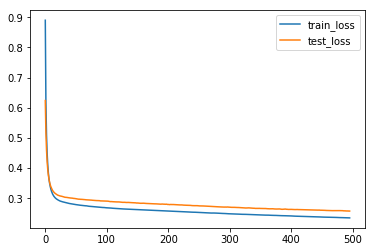

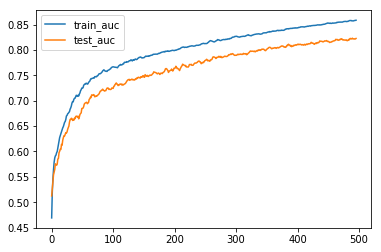

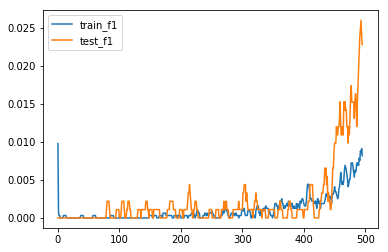

iter 550 train_loss 0.23128 test_loss 0.037634
iter 550 train_f1 0.02338 test_f1 0.037634

iter 600 train_loss 0.22874 test_loss 0.047745
iter 600 train_f1 0.04298 test_f1 0.047745

iter 650 train_loss 0.22638 test_loss 0.068421
iter 650 train_f1 0.06364 test_f1 0.068421

iter 700 train_loss 0.22362 test_loss 0.092308
iter 700 train_f1 0.10140 test_f1 0.092308

iter 750 train_loss 0.22142 test_loss 0.11083
iter 750 train_f1 0.10999 test_f1 0.11083

iter 800 train_loss 0.21943 test_loss 0.13333
iter 800 train_f1 0.14700 test_f1 0.13333

iter 850 train_loss 0.21766 test_loss 0.15789
iter 850 train_f1 0.16212 test_f1 0.15789

iter 900 train_loss 0.21631 test_loss 0.15677
iter 900 train_f1 0.16551 test_f1 0.15677

iter 950 train_loss 0.21409 test_loss 0.16588
iter 950 train_f1 0.18319 test_f1 0.16588

iter 1000 train_loss 0.21245 test_loss 0.16114
iter 1000 train_f1 0.19456 test_f1 0.16114



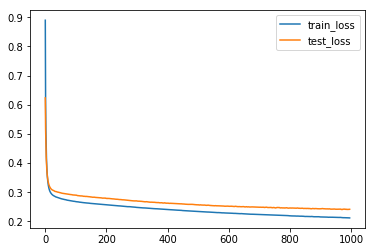

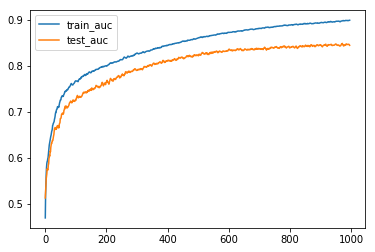

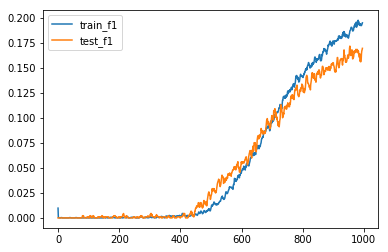

In [33]:
stats_noisy = train_model(model_noisy, X_train, y_train, X_test, y_test, batch_size=batch_size, iters=1000)

iter 1050 train_loss 0.21057 test_loss 0.16471
iter 1050 train_f1 0.21003 test_f1 0.16471

iter 1100 train_loss 0.20907 test_loss 0.1949
iter 1100 train_f1 0.23219 test_f1 0.1949

iter 1150 train_loss 0.20744 test_loss 0.17371
iter 1150 train_f1 0.24330 test_f1 0.17371

iter 1200 train_loss 0.20645 test_loss 0.18981
iter 1200 train_f1 0.24238 test_f1 0.18981

iter 1250 train_loss 0.20514 test_loss 0.1907
iter 1250 train_f1 0.24227 test_f1 0.1907

iter 1300 train_loss 0.20447 test_loss 0.1814
iter 1300 train_f1 0.26675 test_f1 0.1814

iter 1350 train_loss 0.20256 test_loss 0.20642
iter 1350 train_f1 0.27795 test_f1 0.20642

iter 1400 train_loss 0.20230 test_loss 0.19026
iter 1400 train_f1 0.29404 test_f1 0.19026

iter 1450 train_loss 0.20030 test_loss 0.20137
iter 1450 train_f1 0.29908 test_f1 0.20137

iter 1500 train_loss 0.19818 test_loss 0.20957
iter 1500 train_f1 0.31618 test_f1 0.20957



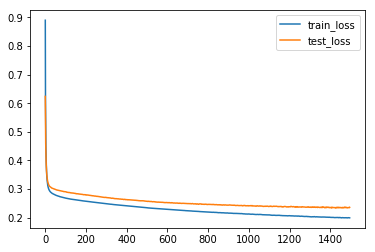

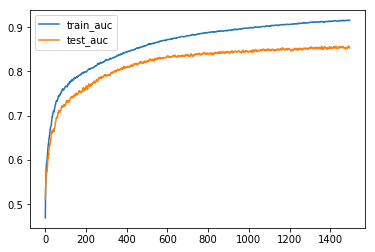

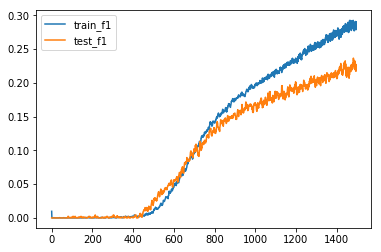

iter 1550 train_loss 0.19816 test_loss 0.22172
iter 1550 train_f1 0.32078 test_f1 0.22172

iter 1600 train_loss 0.19678 test_loss 0.2156
iter 1600 train_f1 0.32832 test_f1 0.2156

iter 1650 train_loss 0.19557 test_loss 0.23767
iter 1650 train_f1 0.33533 test_f1 0.23767

iter 1700 train_loss 0.19713 test_loss 0.21364
iter 1700 train_f1 0.34663 test_f1 0.21364

iter 1750 train_loss 0.19603 test_loss 0.21719
iter 1750 train_f1 0.35524 test_f1 0.21719

iter 1800 train_loss 0.19406 test_loss 0.22374
iter 1800 train_f1 0.34808 test_f1 0.22374

iter 1850 train_loss 0.19367 test_loss 0.23874
iter 1850 train_f1 0.36111 test_f1 0.23874

iter 1900 train_loss 0.19203 test_loss 0.24324
iter 1900 train_f1 0.36845 test_f1 0.24324

iter 1950 train_loss 0.19097 test_loss 0.25056
iter 1950 train_f1 0.37304 test_f1 0.25056

iter 2000 train_loss 0.18999 test_loss 0.26222
iter 2000 train_f1 0.37587 test_f1 0.26222



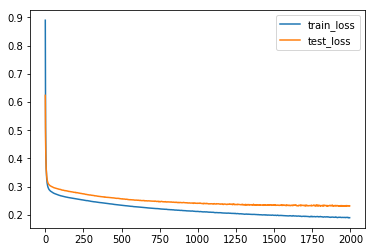

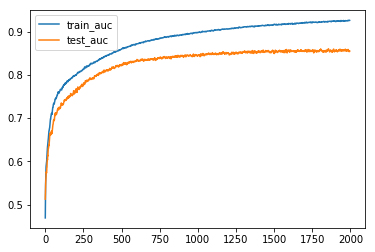

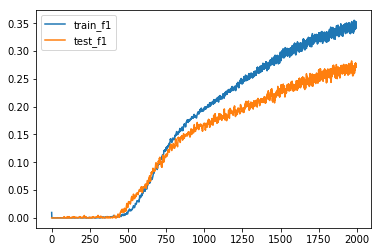

In [34]:
train_model(model_noisy, X_train, y_train, X_test, y_test, batch_size=batch_size, iters=1000, stats=stats_noisy)

iter 2050 train_loss 0.18904 test_loss 0.26432
iter 2050 train_f1 0.37318 test_f1 0.26432

iter 2100 train_loss 0.18905 test_loss 0.23423
iter 2100 train_f1 0.38842 test_f1 0.23423

iter 2150 train_loss 0.18767 test_loss 0.25503
iter 2150 train_f1 0.38355 test_f1 0.25503

iter 2200 train_loss 0.18682 test_loss 0.26106
iter 2200 train_f1 0.38796 test_f1 0.26106

iter 2250 train_loss 0.18809 test_loss 0.2649
iter 2250 train_f1 0.39241 test_f1 0.2649

iter 2300 train_loss 0.18470 test_loss 0.2807
iter 2300 train_f1 0.39747 test_f1 0.2807

iter 2350 train_loss 0.18506 test_loss 0.26398
iter 2350 train_f1 0.41077 test_f1 0.26398

iter 2400 train_loss 0.18506 test_loss 0.24944
iter 2400 train_f1 0.41117 test_f1 0.24944

iter 2450 train_loss 0.18404 test_loss 0.25551
iter 2450 train_f1 0.41495 test_f1 0.25551

iter 2500 train_loss 0.18498 test_loss 0.24664
iter 2500 train_f1 0.43350 test_f1 0.24664



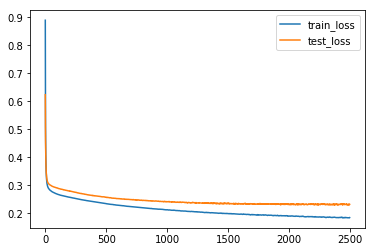

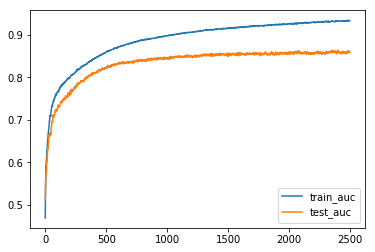

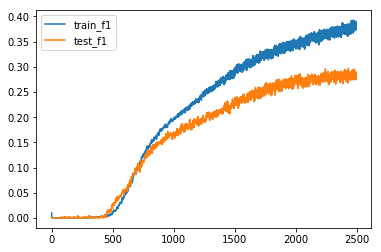

iter 2550 train_loss 0.18183 test_loss 0.2649
iter 2550 train_f1 0.41934 test_f1 0.2649

iter 2600 train_loss 0.18109 test_loss 0.27887
iter 2600 train_f1 0.42182 test_f1 0.27887

iter 2650 train_loss 0.18229 test_loss 0.25778
iter 2650 train_f1 0.44711 test_f1 0.25778

iter 2700 train_loss 0.18222 test_loss 0.24664
iter 2700 train_f1 0.44081 test_f1 0.24664

iter 2750 train_loss 0.17870 test_loss 0.28139
iter 2750 train_f1 0.42081 test_f1 0.28139

iter 2800 train_loss 0.17984 test_loss 0.24889
iter 2800 train_f1 0.43815 test_f1 0.24889

iter 2850 train_loss 0.17775 test_loss 0.27948
iter 2850 train_f1 0.43391 test_f1 0.27948

iter 2900 train_loss 0.17795 test_loss 0.26049
iter 2900 train_f1 0.44566 test_f1 0.26049

iter 2950 train_loss 0.18015 test_loss 0.24161
iter 2950 train_f1 0.47040 test_f1 0.24161

iter 3000 train_loss 0.17678 test_loss 0.28758
iter 3000 train_f1 0.45140 test_f1 0.28758



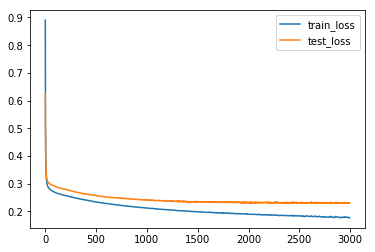

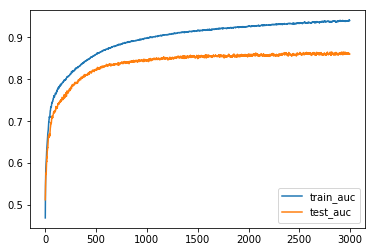

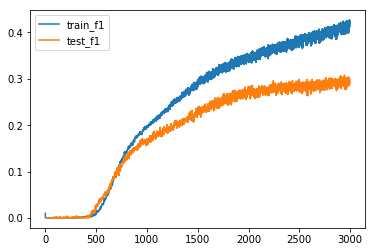

In [35]:
train_model(model_noisy, X_train, y_train, X_test, y_test, batch_size=batch_size, iters=1000, stats=stats_noisy)

In [36]:
predicted_probality = RnnPredictor(model_noisy).predict_proba(X_test, device)

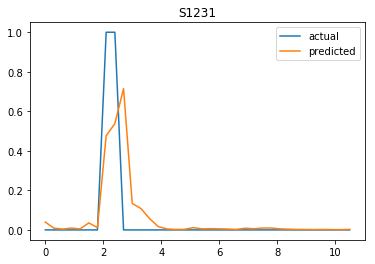

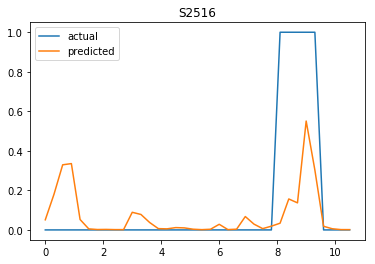

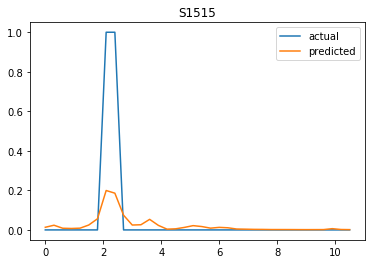

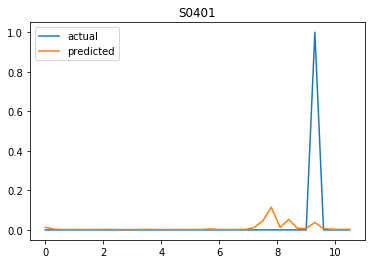

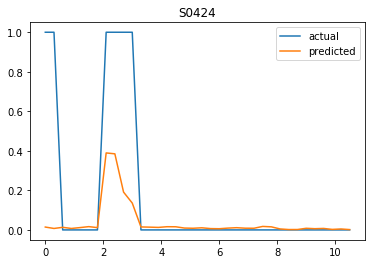

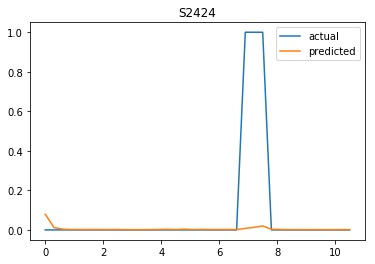

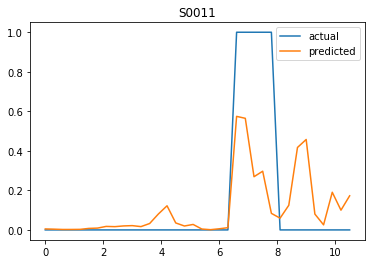

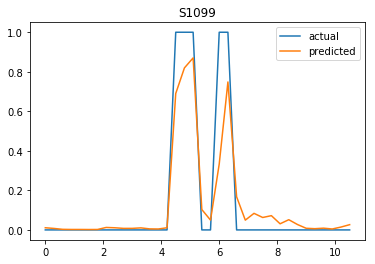

In [37]:
for sname, actual, pred in zip(snames_test[:32], y_test, predicted_probality):
    if np.sum(actual) != 0:
        plt.title(sname)
        l = len(actual)
        plt.plot(np.arange(l) * FRAME_SEC, actual, label='actual')
        plt.plot(np.arange(l) * FRAME_SEC, pred, label='predicted')
        plt.legend()
        plt.show()


## Обучаем модель на данных без добавленного шума

In [38]:
X_train, X_test, y_train, y_test, snames_train, snames_test = split(data)

In [39]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2461, 36, 148) (274, 36, 148) (2461, 36) (274, 36)


In [40]:
model_clean = LibrosaFeaturesRnn(fbank_features, mfcc_features, 
                           hidden_size=hidden_size,
                           batch_size=batch_size)

model_clean = model_clean.to(device)
train_iter = 1

iter 50 train_loss 0.27431 test_loss 0.0
iter 50 train_f1 0.00000 test_f1 0.0

iter 100 train_loss 0.25816 test_loss 0.0
iter 100 train_f1 0.00000 test_f1 0.0

iter 150 train_loss 0.24941 test_loss 0.0
iter 150 train_f1 0.00000 test_f1 0.0

iter 200 train_loss 0.24260 test_loss 0.0054945
iter 200 train_f1 0.00474 test_f1 0.0054945

iter 250 train_loss 0.23822 test_loss 0.0
iter 250 train_f1 0.00939 test_f1 0.0

iter 300 train_loss 0.23238 test_loss 0.016349
iter 300 train_f1 0.02327 test_f1 0.016349

iter 350 train_loss 0.22780 test_loss 0.026738
iter 350 train_f1 0.03704 test_f1 0.026738

iter 400 train_loss 0.22425 test_loss 0.026738
iter 400 train_f1 0.04766 test_f1 0.026738

iter 450 train_loss 0.22071 test_loss 0.042216
iter 450 train_f1 0.07547 test_f1 0.042216

iter 500 train_loss 0.21723 test_loss 0.04712
iter 500 train_f1 0.09651 test_f1 0.04712



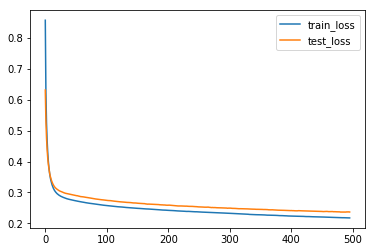

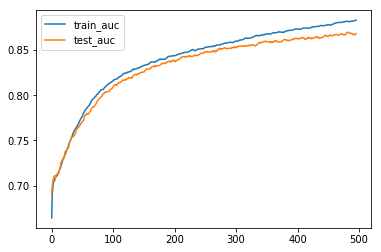

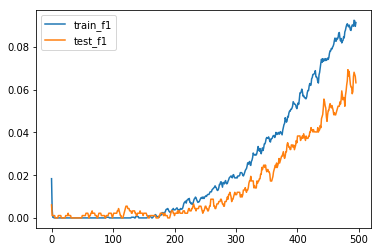

iter 550 train_loss 0.21497 test_loss 0.076923
iter 550 train_f1 0.11533 test_f1 0.076923

iter 600 train_loss 0.21285 test_loss 0.12407
iter 600 train_f1 0.11722 test_f1 0.12407

iter 650 train_loss 0.21052 test_loss 0.12407
iter 650 train_f1 0.14979 test_f1 0.12407

iter 700 train_loss 0.20828 test_loss 0.14251
iter 700 train_f1 0.16901 test_f1 0.14251

iter 750 train_loss 0.20641 test_loss 0.15572
iter 750 train_f1 0.17614 test_f1 0.15572

iter 800 train_loss 0.20471 test_loss 0.16706
iter 800 train_f1 0.18969 test_f1 0.16706

iter 850 train_loss 0.20191 test_loss 0.19718
iter 850 train_f1 0.20718 test_f1 0.19718

iter 900 train_loss 0.20062 test_loss 0.20833
iter 900 train_f1 0.22372 test_f1 0.20833

iter 950 train_loss 0.20032 test_loss 0.21659
iter 950 train_f1 0.22445 test_f1 0.21659

iter 1000 train_loss 0.19853 test_loss 0.22426
iter 1000 train_f1 0.23482 test_f1 0.22426



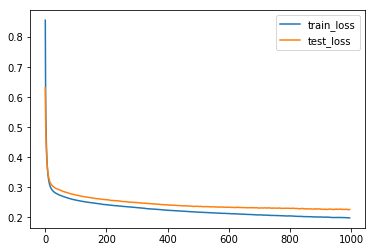

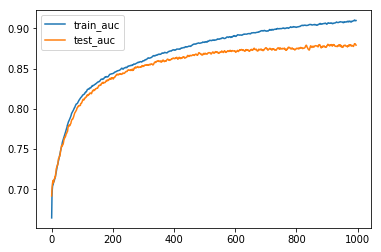

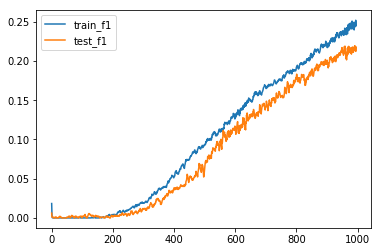

In [41]:
stats_сlean = train_model(model_clean, X_train, y_train, X_test, y_test, batch_size=batch_size, iters=1000)

iter 1050 train_loss 0.19809 test_loss 0.2382
iter 1050 train_f1 0.23138 test_f1 0.2382

iter 1100 train_loss 0.19626 test_loss 0.25778
iter 1100 train_f1 0.23686 test_f1 0.25778

iter 1150 train_loss 0.19529 test_loss 0.24944
iter 1150 train_f1 0.25345 test_f1 0.24944

iter 1200 train_loss 0.19509 test_loss 0.27766
iter 1200 train_f1 0.25361 test_f1 0.27766

iter 1250 train_loss 0.19366 test_loss 0.28448
iter 1250 train_f1 0.26771 test_f1 0.28448

iter 1300 train_loss 0.19338 test_loss 0.29851
iter 1300 train_f1 0.27237 test_f1 0.29851

iter 1350 train_loss 0.19103 test_loss 0.27332
iter 1350 train_f1 0.28936 test_f1 0.27332

iter 1400 train_loss 0.19183 test_loss 0.2906
iter 1400 train_f1 0.28220 test_f1 0.2906

iter 1450 train_loss 0.19047 test_loss 0.29412
iter 1450 train_f1 0.28238 test_f1 0.29412

iter 1500 train_loss 0.18881 test_loss 0.28694
iter 1500 train_f1 0.29834 test_f1 0.28694



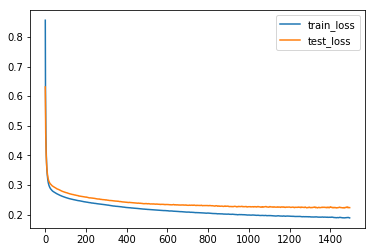

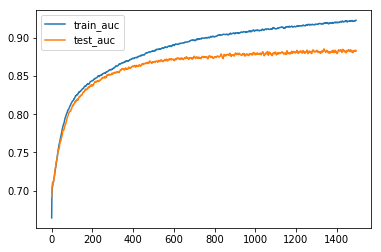

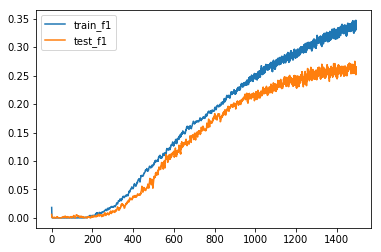

iter 1550 train_loss 0.18789 test_loss 0.29122
iter 1550 train_f1 0.33582 test_f1 0.29122

iter 1600 train_loss 0.18716 test_loss 0.30085
iter 1600 train_f1 0.33478 test_f1 0.30085

iter 1650 train_loss 0.18517 test_loss 0.30021
iter 1650 train_f1 0.33250 test_f1 0.30021

iter 1700 train_loss 0.18484 test_loss 0.29474
iter 1700 train_f1 0.32770 test_f1 0.29474

iter 1750 train_loss 0.18529 test_loss 0.32231
iter 1750 train_f1 0.32071 test_f1 0.32231

iter 1800 train_loss 0.18360 test_loss 0.31365
iter 1800 train_f1 0.32832 test_f1 0.31365

iter 1850 train_loss 0.18449 test_loss 0.31902
iter 1850 train_f1 0.32282 test_f1 0.31902

iter 1900 train_loss 0.18301 test_loss 0.32444
iter 1900 train_f1 0.34938 test_f1 0.32444

iter 1950 train_loss 0.18238 test_loss 0.31967
iter 1950 train_f1 0.34342 test_f1 0.31967

iter 2000 train_loss 0.18102 test_loss 0.32998
iter 2000 train_f1 0.33375 test_f1 0.32998



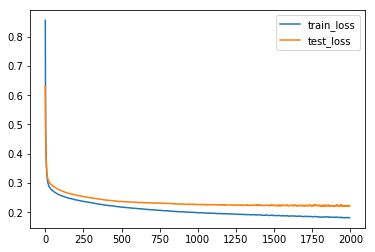

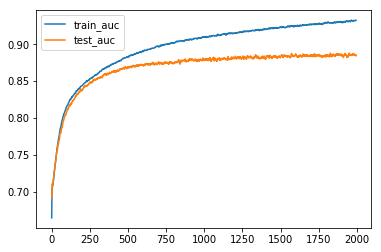

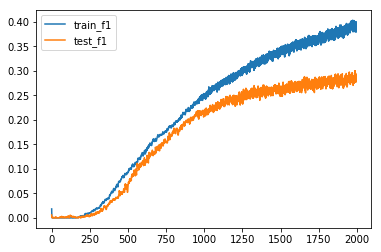

In [42]:
train_model(model_clean, X_train, y_train, X_test, y_test, batch_size=batch_size, iters=1000, stats=stats_сlean)

iter 2050 train_loss 0.18121 test_loss 0.32064
iter 2050 train_f1 0.33271 test_f1 0.32064

iter 2100 train_loss 0.18060 test_loss 0.33134
iter 2100 train_f1 0.34346 test_f1 0.33134

iter 2150 train_loss 0.18045 test_loss 0.32389
iter 2150 train_f1 0.34637 test_f1 0.32389

iter 2200 train_loss 0.17853 test_loss 0.33333
iter 2200 train_f1 0.35793 test_f1 0.33333

iter 2250 train_loss 0.17812 test_loss 0.3253
iter 2250 train_f1 0.36755 test_f1 0.3253

iter 2300 train_loss 0.17818 test_loss 0.35108
iter 2300 train_f1 0.35894 test_f1 0.35108

iter 2350 train_loss 0.17771 test_loss 0.35728
iter 2350 train_f1 0.35758 test_f1 0.35728

iter 2400 train_loss 0.17698 test_loss 0.34331
iter 2400 train_f1 0.38200 test_f1 0.34331

iter 2450 train_loss 0.17502 test_loss 0.35798
iter 2450 train_f1 0.37828 test_f1 0.35798

iter 2500 train_loss 0.17422 test_loss 0.33268
iter 2500 train_f1 0.38702 test_f1 0.33268



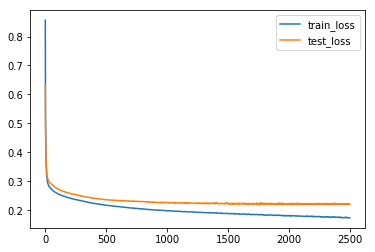

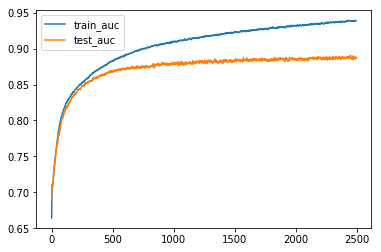

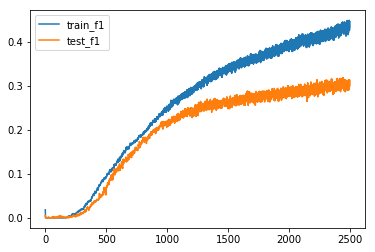

iter 2550 train_loss 0.17303 test_loss 0.35225
iter 2550 train_f1 0.39013 test_f1 0.35225

iter 2600 train_loss 0.17315 test_loss 0.35409
iter 2600 train_f1 0.39904 test_f1 0.35409

iter 2650 train_loss 0.17330 test_loss 0.35178
iter 2650 train_f1 0.40214 test_f1 0.35178

iter 2700 train_loss 0.17077 test_loss 0.34241
iter 2700 train_f1 0.42267 test_f1 0.34241

iter 2750 train_loss 0.17261 test_loss 0.3619
iter 2750 train_f1 0.40217 test_f1 0.3619

iter 2800 train_loss 0.17194 test_loss 0.36122
iter 2800 train_f1 0.39521 test_f1 0.36122

iter 2850 train_loss 0.17014 test_loss 0.37066
iter 2850 train_f1 0.41187 test_f1 0.37066

iter 2900 train_loss 0.16852 test_loss 0.34902
iter 2900 train_f1 0.42958 test_f1 0.34902

iter 2950 train_loss 0.17083 test_loss 0.38563
iter 2950 train_f1 0.40694 test_f1 0.38563

iter 3000 train_loss 0.17069 test_loss 0.36154
iter 3000 train_f1 0.41289 test_f1 0.36154



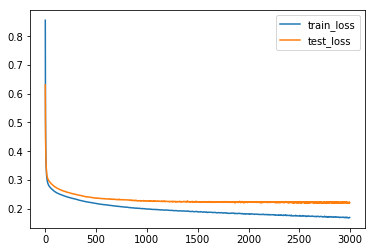

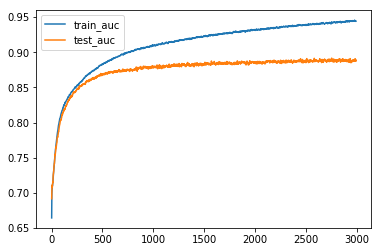

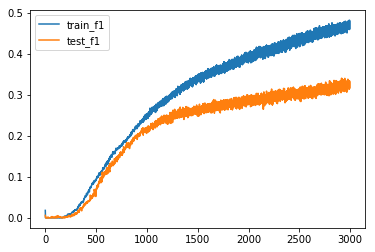

In [43]:
train_model(model_clean, X_train, y_train, X_test, y_test, batch_size=batch_size, iters=1000, stats=stats_сlean)

## Сравнение моделей

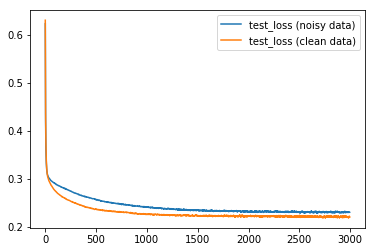

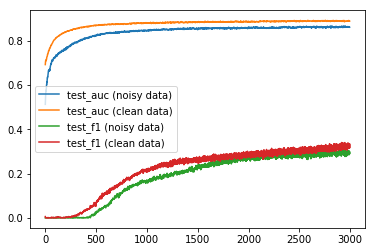

In [44]:
plt.plot(window_mean(stats_noisy.test_losses), label='test_loss (noisy data)')
plt.plot(window_mean(stats_сlean.test_losses), label='test_loss (clean data)')

plt.legend()
plt.show()

plt.plot(window_mean(stats_noisy.test_auc), label='test_auc (noisy data)')
plt.plot(window_mean(stats_сlean.test_auc), label='test_auc (clean data)')
plt.plot(window_mean(stats_noisy.test_f1), label='test_f1 (noisy data)')
plt.plot(window_mean(stats_сlean.test_f1), label='test_f1 (clean data)')

plt.legend()
plt.show()

In [54]:
_, X_test_noisy, _, y_test_noisy, _, sname_test_noisy = split(data_noisy)

In [55]:
snames_test == sname_test_noisy

True

In [56]:
scores_noisy = RnnPredictor(model_noisy).predict_proba(X_test_noisy, device)
scores_clean = RnnPredictor(model_clean).predict_proba(X_test_noisy, device)

In [57]:
from sklearn.metrics import precision_recall_curve

def plot_pr_curve(testy, scores, label=''):
    plt.title('precision recall curve')
    precision, recall, thresholds = precision_recall_curve(testy, scores)
    plt.plot(recall, precision, label=label)
    plt.xlabel('recall')
    plt.ylabel('precision')

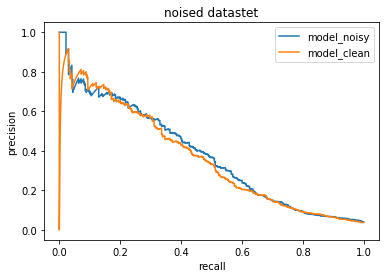

In [58]:
plot_pr_curve(y_test_noisy.ravel(), scores_noisy.ravel(), 'model_noisy')
plot_pr_curve(y_test_noisy.ravel(), scores_clean.ravel(), 'model_clean')
plt.title('noised datastet')
    
plt.legend()
plt.show()

In [59]:
_, X_test_clean, _, y_test_clean, _, sname_test_clean = split(data)

In [60]:
scores_noisy = RnnPredictor(model_noisy).predict_proba(X_test_clean, device)
scores_clean = RnnPredictor(model_clean).predict_proba(X_test_clean, device)

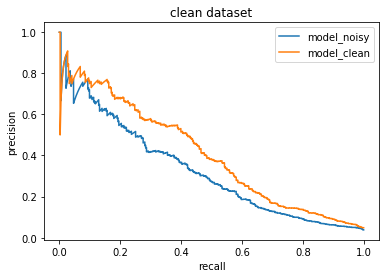

In [61]:
plot_pr_curve(y_test_noisy.ravel(), scores_noisy.ravel(), 'model_noisy')
plot_pr_curve(y_test_noisy.ravel(), scores_clean.ravel(), 'model_clean')
plt.title('clean dataset')
plt.legend()
plt.show()

## Cохранение моделей

In [62]:
torch.save(model_noisy.state_dict(), 'models/rnn_model_for_noisy_dataset.ptr')

In [63]:
torch.save(model_clean.state_dict(), 'models/rnn_model_for_clean_dataset.ptr')